In [1]:
import torch
from torch import nn
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from tools.plots import plot_samples
from tools.ANN import train_network
%load_ext autoreload
%autoreload 2

# Define an ANN

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_ann():
    Classifyer = nn.Sequential(
        nn.Linear(400, 25),
        nn.ReLU(),
        nn.Linear(25, 10)
    )
    Classifyer = Classifyer.to(device)
    return Classifyer

# Load Dataset

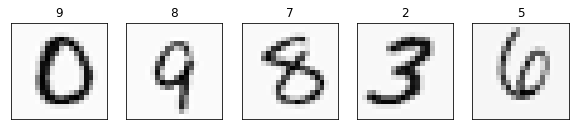

In [3]:
dataset = loadmat("trg1.mat")
X, Y = dataset['X'], dataset['y']
X = torch.Tensor(X)
Y = torch.LongTensor(Y).flatten()
Y = Y - 1
ind = np.random.randint(0, len(X), 5)
fig, axes = plot_samples(X[ind], Y[ind], nrows=1, figsize=(10, 6))
plt.show()

# Randomly split the dataset to training dataset and test dataset

In [6]:
X = X.to(device)
Y = Y.to(device)
ind = np.arange(X.shape[0])
np.random.shuffle(ind)
train_size = int(ind.size * 0.8)
X_train, Y_train = X[ind[:train_size]], Y[ind[:train_size]]
X_test, Y_test = X[ind[train_size:]], Y[ind[train_size:]]

In [7]:
print("number of samples included in training dataset: ", X_train.shape[0])
print("number of samples included in test dataset: ", X_test.shape[0])

number of samples included in training dataset:  4000
number of samples included in test dataset:  1000


# Train the Network without regulation

For classification problem, the loss function (or potential) is Cross Entropy

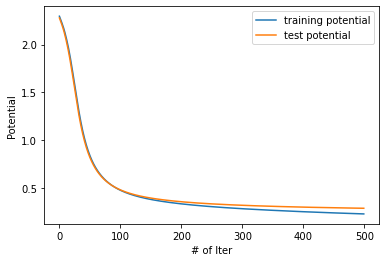

In [8]:
Classifyer = get_ann()
training_loss, test_loss = train_network(Classifyer, 
                                         (X_train, Y_train), (X_test, Y_test), 
                                         500, lr=0.2, Lambda=0.)

plt.plot(training_loss, label="training potential")
plt.plot(test_loss, label="test potential")
plt.xlabel("# of Iter")
plt.ylabel("Potential")
plt.legend()

# Include L1 Regulation
The loss become:
$$L(\theta | X, Y) = CrossEntropy(\theta |X, Y) + \lambda \sum_i |\theta_i|$$

In [14]:
lambda_list = np.linspace(0, 0.01, 20)
loss_list = []
for l in lambda_list:
    Classifyer = get_ann()
    loss_list.append(train_network(Classifyer,
                                   (X_train, Y_train), (X_test, Y_test),
                                   500, lr=0.1, Lambda=l)[1])
    del Classifyer

[0.33979888 0.33761368 0.34333777 0.34238409 0.34151911 0.34050778
 0.3376788  0.34885135 0.3457874  0.34317323 0.33695454 0.34024219
 0.34431626 0.33689026 0.33621691 0.33858563 0.34437693 0.34032555
 0.33858368 0.34954771]


Text(0, 0.5, 'test loss')

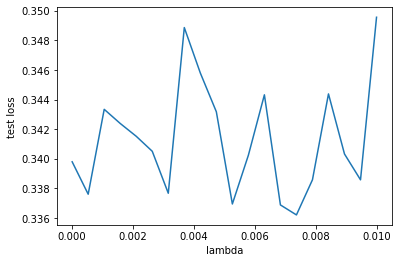

In [15]:
final_loss = np.zeros(lambda_list.size)
for i in range(lambda_list.size):
    final_loss[i] = np.mean(loss_list[i][-20:])
print(final_loss)
plt.plot(lambda_list, final_loss)
plt.xlabel("lambda")
plt.ylabel("test loss")

#### As this artifical neural network for this dataset do not really have overfitting problem, the regulation doesn't help a lot, I can't find an optimal value in this problem

#### Since I haven't found an optimal value, I used the network trained at lambda = 0, and got 91.6% accuracy.

In [16]:
Classifyer = get_ann()
training_loss, test_loss = train_network(Classifyer, 
                                         (X_train, Y_train), (X_test, Y_test), 
                                         500, lr=0.2, Lambda=0.)
predicted_result = torch.argmax(Classifyer(X_test), axis=1)

acc = (predicted_result == Y_test).sum() / Y_test.shape[0]
print(f"The success rate is {acc}")
cm = confusion_matrix(Y_test.cpu(), predicted_result.cpu())

The success rate is 0.9160000681877136


# confusion matrix 

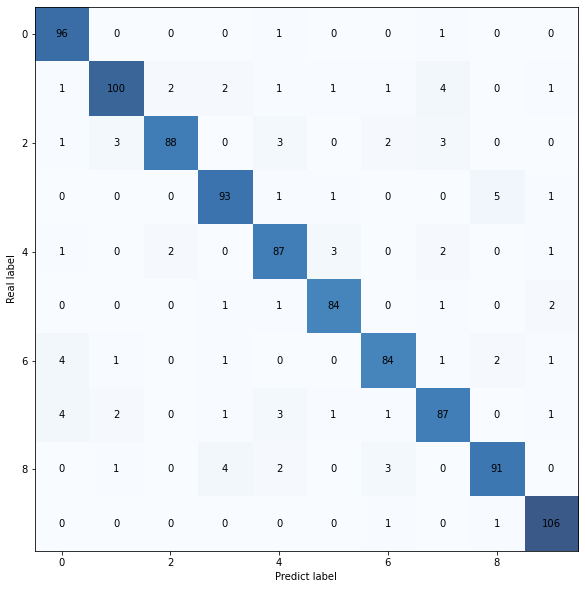

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap="Blues", alpha=0.8)
for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predict label")
plt.ylabel("Real label")
plt.show()